# Problem statement - From LMS portal 

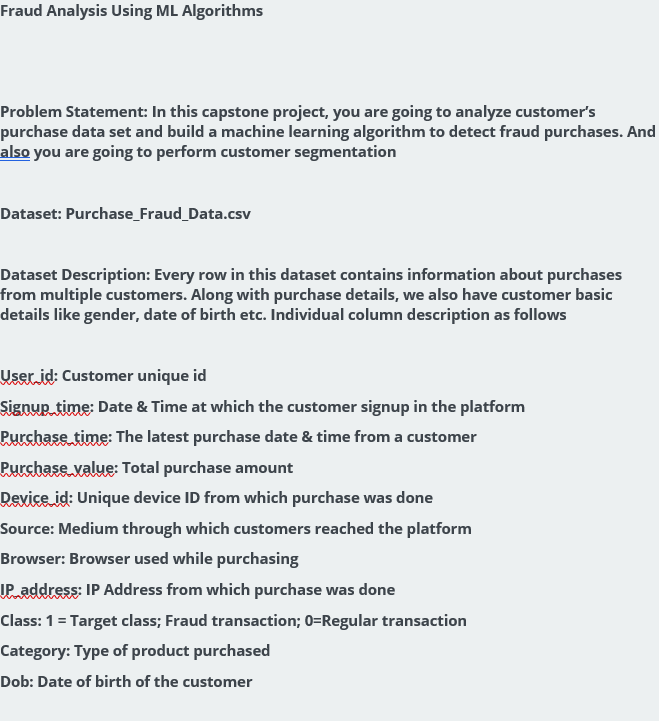

# Introduction to Fraud detection:
Typical challenges associated with fraud detection
Introduction to fraud detection
Types:
Insurance
Credit card
Identity theft
Money laundering
Tax evasion
Healthcare
Product warranty
e-commerce businesses must continuously assess the legitimacy of client transactions
Detecting fraud is challenging:
Uncommon; < 0.01% of transactions
Attempts are made to conceal fraud
Behavior evolves
Fraudulent activities perpetrated by networks - organized crime
Fraud detection requires training an algorithm to identify concealed observations from any normal observations
Fraud analytics teams:
Often use rules based systems, based on manually set thresholds and experience
Check the news
Receive external lists of fraudulent accounts and names
suspicious names or track an external hit list from police to reference check against the client base
Sometimes use machine learning algorithms to detect fraud or suspicious behavior
Existing sources can be used as inputs into the ML model
Verify the veracity of rules based labels

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Purchase_Fraud_Data.csv")

# 1. Data Description

In [3]:
df.head(2)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,apparels,2-1-1962


In [4]:
df.shape

(151112, 12)

In [5]:
df.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
ip_address        float64
class               int64
category           object
dob                object
dtype: object

In [6]:
df.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'ip_address', 'class',
       'category', 'dob'],
      dtype='object')

## 1.1 Checking Fraud to non fraud ratio

### Checking the class balance 

In [7]:
df['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

In [8]:
df['class'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    90.6%
1     9.4%
Name: class, dtype: object

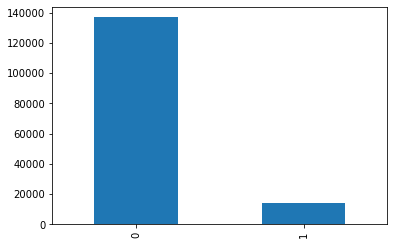

In [9]:
df['class'].value_counts().plot(kind='bar');

### 1.1 Summary: Negative class (Fraud) samples <font color='red'> are less than 10%</font> of overall samples. 
    This is typical real world scenario for such transactions. We will have to apply some techniques like SMOTE to handle this class imbalance 

### 1.1.1 Handling Missing Values 

In [10]:
df.isnull().sum()

user_id              0
signup_time          0
purchase_time        0
purchase_value       0
device_id            0
source               0
browser              0
sex               4927
ip_address           0
class                0
category             0
dob               4924
dtype: int64

In [11]:
df.isna().sum()/len(df)*100

user_id           0.000000
signup_time       0.000000
purchase_time     0.000000
purchase_value    0.000000
device_id         0.000000
source            0.000000
browser           0.000000
sex               3.260496
ip_address        0.000000
class             0.000000
category          0.000000
dob               3.258510
dtype: float64

In [12]:
df_temp1 = df[df.sex.isna()]

In [13]:
df_temp1['class'].value_counts()

0    4464
1     463
Name: class, dtype: int64

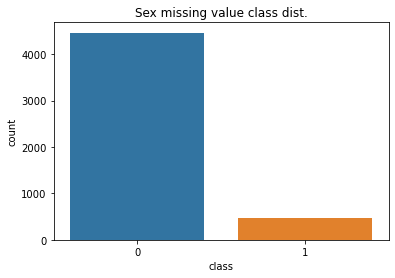

In [14]:
sns.countplot(x='class',data = df_temp1).set(title='Sex missing value class dist.');

In [15]:
df_temp2 = df[df.dob.isna()]
df_temp2['class'].value_counts()

0    4457
1     467
Name: class, dtype: int64

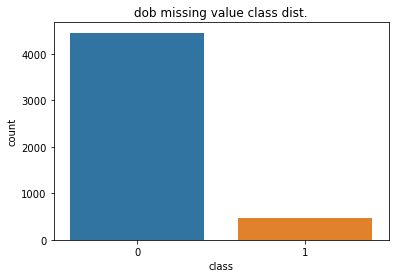

In [16]:
sns.countplot(x='class',data = df_temp2).set(title='dob missing value class dist.');

### 1.1.1 Inference: Sex and dob have <5% values as missing values, droping them 

In [17]:
df = df.dropna(how = 'any', axis = 0)
df.dropna(how = 'any', axis = 0).isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
ip_address        0
class             0
category          0
dob               0
dtype: int64

## 1.2 Exploratory Data analysis 

### 1.2.1 Checking for skewnes in data 

In [18]:
df.skew()

user_id           0.001247
purchase_value    0.000862
ip_address       -0.007756
class             2.789898
dtype: float64

### 1.2.2 Understand any obvious co-relations

In [19]:
df.corr()

,user_id,purchase_value,ip_address,class
user_id,1.000000,0.002933,-0.003462,0.002490
purchase_value,0.002933,1.000000,-0.001130,0.003700
ip_address,-0.003462,-0.001130,1.000000,-0.004706
class,0.002490,0.003700,-0.004706,1.000000


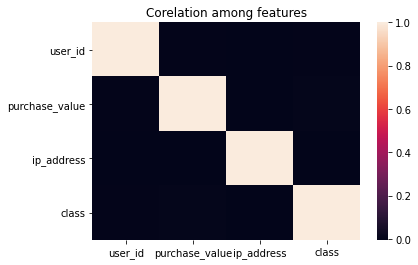

In [20]:
sns.heatmap(df.corr()).set(title='Corelation among features');


### Inference: No strong co-relation between any features 

### 1.2.3 Distribution of Fruad transaction w.r.t sex 

[Text(0.5, 1.0, 'Fraud transaction Male Vs Female')]

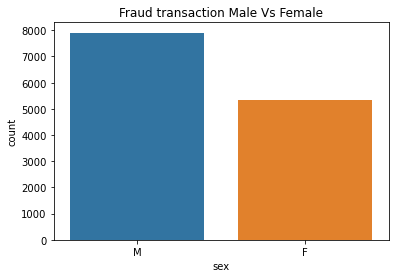

In [21]:
sns.countplot( x = 'sex', data = df[df['class'] == 1] ).set(title='Fraud transaction Male Vs Female')

In [22]:
df[(df['class'] == 1) & (df['sex'] == 'M')]['user_id'].count()

7908

In [23]:
### Percentage fraudlent transaction by sex 
print(" ** PERCENTAGE of Fraud transaction by \"Male\"")
df[(df['class'] == 1) & (df['sex'] == 'M')]['user_id'].count() / (len(df[df['class'] == 1]) - 4927) * 100

 ** PERCENTAGE of Fraud transaction by "Male"


95.12811259473114

In [24]:
### Percentage fraudlent transaction by sex 
print(" ** PERCENTAGE of Fraud transaction by \"Female\"")
df[(df['class'] == 1) & (df['sex'] == 'F')]['user_id'].count() / (len(df[df['class'] == 1]) - 4927) * 100

 ** PERCENTAGE of Fraud transaction by "Female"


64.14050282689763

### 1.2.3 Summary: Sex distribution 
- <font color='red'> 88% of total</font>  fraud transaction were reported by class "M"
- <font color='green'> 59% of total</font>  fraud transaction were reported by class "F"

### 1.2.3 Distribution of Fruad transaction w.r.t device used 

In [25]:
# Total number of unique devices
len(df['device_id'].unique())

129482

In [26]:
len(df[df['class'] == 1]['device_id'].value_counts().unique())

18

#### 18 of 129482 unique devices used for Fraud transaction 

In [27]:
# Was there any device which was used more than "1 imes" for Fraud transaction
df[df['class'] == 1]['device_id'].value_counts().unique()

array([19, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,
        1], dtype=int64)

In [28]:
df[df['class'] == 1]['device_id'].value_counts().loc[lambda x : x >= 2]

EQYVNEGOFLAWK    19
ZUSVMDEZRBDTX    19
CQTUVBYIWWWBC    19
FFWAQIABHGYJC    17
NGQCKIADMZORL    17
                 ..
EGFRVADWREBCF     2
EQUFYZKHAMAWI     2
JAXRTNEFHQWCC     2
XYXPBIHYXPNHV     2
IVJZWKVLSCEFG     2
Name: device_id, Length: 1008, dtype: int64

In [29]:
df_fraud_device = df[df['class'] == 1]['device_id'].value_counts().loc[lambda x : x >= 2]

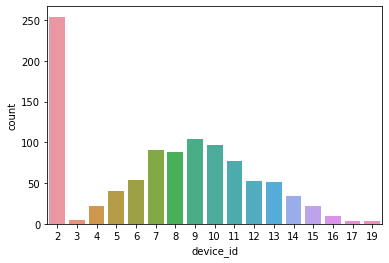

In [30]:
sns.countplot(x= df_fraud_device.index, data= df_fraud_device);

In [31]:
### Number of unique devices with more than 1 fraud transaction 
len(df[df['class'] == 1]['device_id'].value_counts().loc[lambda x : x >= 2].unique())

17

In [32]:
### Number of unique devices with more than 5 fraud transaction 
len(df[df['class'] == 1]['device_id'].value_counts().loc[lambda x : x >= 5].unique())

14

### 1.2.3 Summary:
<font color='red'> 18 </font>/12948 unique devices – Fraud Txn <br>
<font color='red'> 17 </font>/12948 unique devices – with more than 2 Fraud Txn <br>
<font color='red'> 14 </font>/12948 unique devices – with more than 5 Fraud Txn


### 1.2.4 Distribution of Fruad transaction w.r.t category

In [33]:
df['category'].unique()

array(['home_essentials', 'apparels', 'electronics', 'health_care',
       'cosmetics'], dtype=object)

In [34]:
df[df['class'] == 1]['category'].value_counts()

electronics        4299
health_care        2279
cosmetics          2253
apparels           2234
home_essentials    2175
Name: category, dtype: int64

In [35]:
df_fraud_cateogary = df[df['class'] == 1]['category'].value_counts()

In [36]:
df_fraud_cateogary= pd.DataFrame(df_fraud_cateogary)

In [37]:
df_fraud_cateogary.sort_values(by='category', ascending=False)

,category
electronics,4299
health_care,2279
cosmetics,2253
apparels,2234
home_essentials,2175


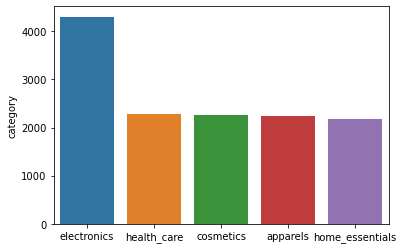

In [38]:
sns.barplot(x =df_fraud_cateogary.index, y = df_fraud_cateogary['category'], data= df_fraud_cateogary);

### 1.2.4 Summary:  <font color='red'> All the categories</font>  had fraud transaction but electronics cateogary was highest 

## 1.2.5 Univariate Analysis 

#### 1.2.5.1 Distribution w.r.t to source 

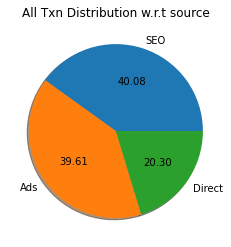

In [39]:
x=df['source'].value_counts()
plt.pie(x,labels=x.index,autopct='%0.2f',shadow=True)
plt.title('All Txn Distribution w.r.t source')
plt.show()

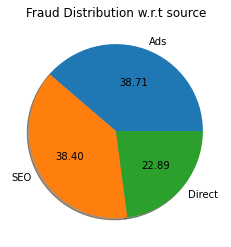

In [40]:
x=df[df['class'] == 1]['source'].value_counts()
plt.pie(x,labels=x.index,autopct='%0.2f',shadow=True)
plt.title('Fraud Distribution w.r.t source')
plt.show()

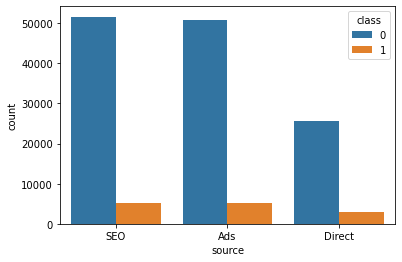

In [41]:
sns.countplot(x='source', data = df, hue='class');


### Inference: SEO (highest)- > Ads  -> Direct

#### 1.2.5.2 Distribution w.r.t to Gender

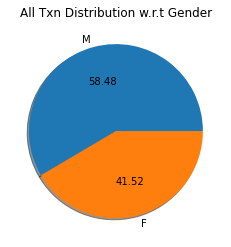

In [42]:
x=df['sex'].value_counts()
plt.pie(x,labels=x.index,autopct='%0.2f',shadow=True)
plt.title('All Txn Distribution w.r.t Gender')
plt.show()

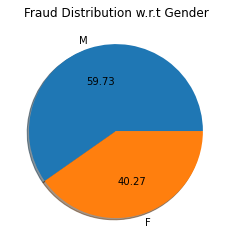

In [43]:
x=df[df['class'] == 1]['sex'].value_counts()
plt.pie(x,labels=x.index,autopct='%0.2f',shadow=True)
plt.title('Fraud Distribution w.r.t Gender')
plt.show()

### Inference: Male percentage is 58% as complared to 41% for females

#### 1.2.5.3 Distribution w.r.t to browser

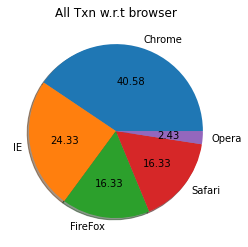

In [44]:
x=df['browser'].value_counts()
plt.pie(x,labels=x.index,autopct='%0.2f',shadow=True)
plt.title('All Txn w.r.t browser')
plt.show()

<AxesSubplot:xlabel='browser', ylabel='count'>

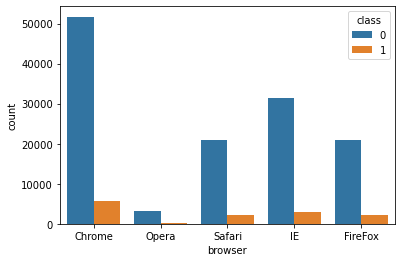

In [45]:
sns.countplot(x='browser', data = df, hue='class')

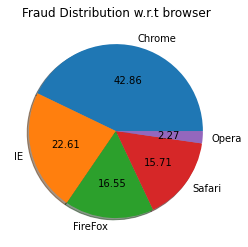

In [46]:
x=df[df['class'] == 1]['browser'].value_counts()
plt.pie(x,labels=x.index,autopct='%0.2f',shadow=True)
plt.title('Fraud Distribution w.r.t browser')
plt.show()

### Inference: Browser usage Chrome -> IE -> FireFox -> Safari-> Opera

### 1.2.6 Bivariate analysis for  <font color='red'>  cateogorical </font>columns 

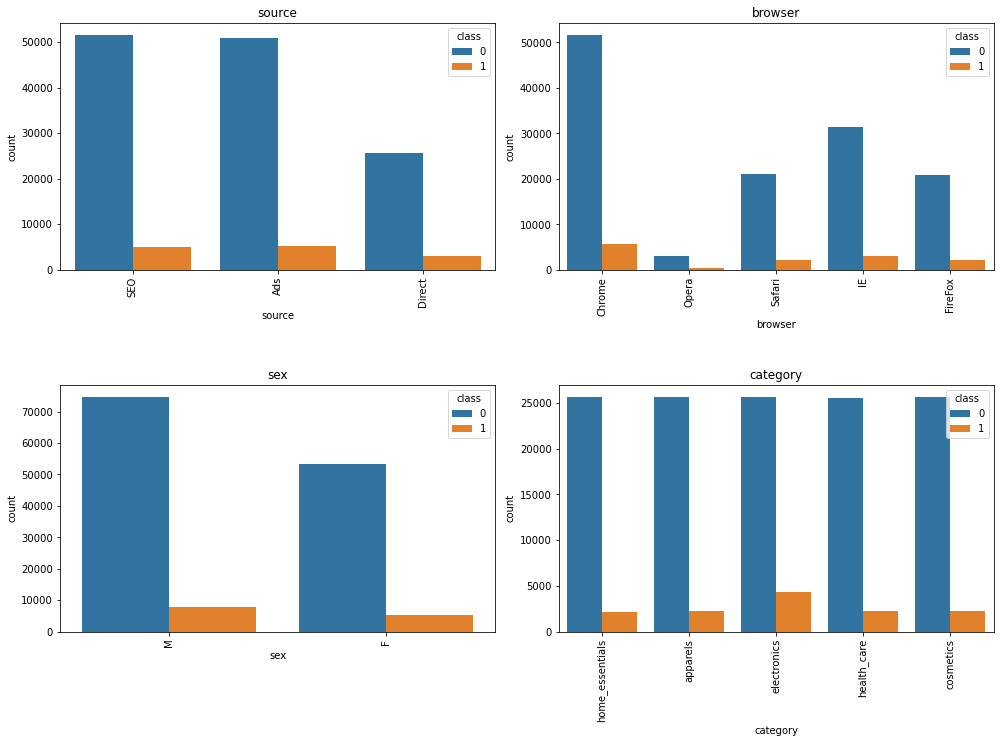

In [47]:
col_list = ['source', 'browser', 'sex','category']
x = 3
y = 2
counter = 1
plt.figure(figsize = [14, 14])
for i in col_list:
    plt.subplot(x,y,counter)
    plt.title(i)
    sns.countplot(x=df[i],hue=df['class'])
    counter = counter+1
    plt.xticks(rotation=90)    
plt.tight_layout()
plt.show()  




### 1.2.7  Segmentation based on <font color='red'> purchased</font>  value 

<AxesSubplot:xlabel='class', ylabel='purchase_value'>

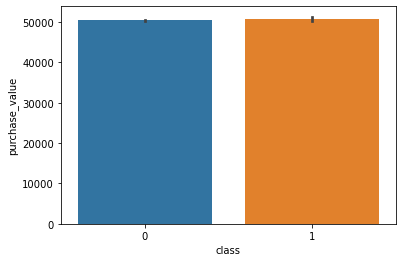

In [48]:
sns.barplot(x = df['class'], y = df['purchase_value'])

[Text(0.5, 1.0, 'Purchase Value Vs Fraud/Regular')]

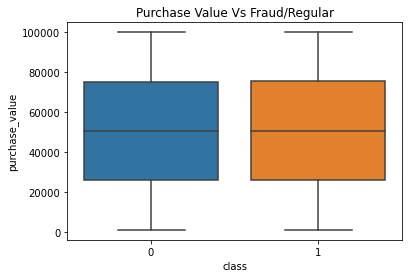

In [49]:
sns.boxplot(x= df['class'], y = df['purchase_value']).set(title='Purchase Value Vs Fraud/Regular')

### Inference: Both fraud and non fraud transactiations were in same purchase value range

### 1.2.7  Binning purchase value into multiple cateogories "

In [50]:
df['purchase_bins'] = pd.cut(df['purchase_value'], 
                             bins=[df['purchase_value'].min(), 10000, 20000, 50000, df['purchase_value'].max()], 
                             labels = ['pur_val_10k','pur_val_20k',
                                       'pur_val_50k','pur_val_max'])

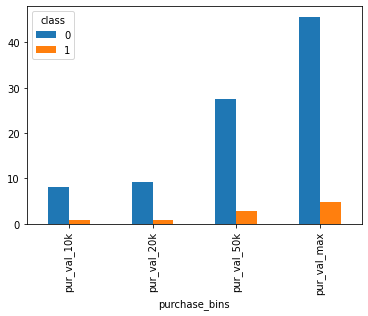

In [51]:
(pd.crosstab(df['purchase_bins'],df['class'],normalize=True)*100).plot(kind="bar")
plt.show()

In [52]:
df['purchase_bins'].value_counts()

pur_val_max    71360
pur_val_50k    43045
pur_val_20k    14252
pur_val_10k    12746
Name: purchase_bins, dtype: int64

### Inference: Highest number of Valid transactions beween 50K - Max value, Fraud transaction is also higher in this range 

# 1.3 Data Pre-Processing 

In [53]:
df.dtypes

user_id              int64
signup_time         object
purchase_time       object
purchase_value       int64
device_id           object
source              object
browser             object
sex                 object
ip_address         float64
class                int64
category            object
dob                 object
purchase_bins     category
dtype: object

In [54]:
df.head(2)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob,purchase_bins
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976,pur_val_max
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,apparels,2-1-1962,pur_val_max


### 1.3.1 Parsing dates as datetime 


In [55]:

df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

In [56]:
df.dtypes

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
ip_address               float64
class                      int64
category                  object
dob                       object
purchase_bins           category
dtype: object

### 1.3.2 Handling IP address 
- We will first convert IP numbers to IPv4 format
- Use ipapi:  will help us fetch location information for a particular IP address

In [57]:
# importing the module
import ipaddress
  
# converting int to IPv4 address
def num_to_ip(ip_addr):
    return ipaddress.ip_address(ip_addr)


In [58]:
df['ipv4'] = df['ip_address'].astype('int64').abs().apply(num_to_ip)

In [59]:
df.head(2)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob,purchase_bins,ipv4
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976,pur_val_max,43.173.1.96
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,apparels,2-1-1962,pur_val_max,20.225.83.219


In [60]:
import requests

def get_location(ip_address):
    
    response = requests.get(f'https://ipapi.co/{ip_address}/json/').json()
    location_data = {
        #"ip": ip_address,
        "city": response.get("city"),
        "region": response.get("region"),
        "country": response.get("country_name")
    }
    return location_data


### Taking lot of time- <font color='red'> Tried overnight but failed </font> . This is an optimization that can be done later 

In [61]:
#df['ipv4_city'] = df['ipv4'].apply(get_location)['city']



# 1.4 Feature Engineering 


### 1.4.1 Adding a new column which will be the difference between signup time and purchase time 

In [62]:
df['purchase_singup_diff'] = df['purchase_time'] - df['signup_time']

In [63]:
df.head(2)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob,purchase_bins,ipv4,purchase_singup_diff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976,pur_val_max,43.173.1.96,52 days 03:51:22
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,apparels,2-1-1962,pur_val_max,20.225.83.219,0 days 04:59:04


### Coverting the time diff into minutes


In [64]:
df['purchase_singup_diff_min'] = df['purchase_singup_diff'].dt.total_seconds()/60

In [65]:
df.head(2)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob,purchase_bins,ipv4,purchase_singup_diff,purchase_singup_diff_min
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976,pur_val_max,43.173.1.96,52 days 03:51:22,75111.366667
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,apparels,2-1-1962,pur_val_max,20.225.83.219,0 days 04:59:04,299.066667


In [66]:
### Coverting the time diff into hrs --> NOT using it
# df['purchase_singup_diff_hrs'] = df['purchase_singup_diff'].astype('timedelta64[h]')

### 1.4.3 Converting purchase time to month, day, hour ( Deliberatly dropping minute and year)

In [67]:
df['purchase_month'] = df['purchase_time'].dt.month
df['purchase_day'] = df['purchase_time'].dt.day
#df['purchase_hour'] = df['purchase_time'].dt.hour # -> not using it in first iteration

#### 1.4.3.1 Convert month number to month name(will be using one hot encoding later)

In [68]:
import calendar
df['Month'] = df['purchase_month'].apply(lambda x: calendar.month_abbr[x])

In [69]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob,purchase_bins,ipv4,purchase_singup_diff,purchase_singup_diff_min,purchase_month,purchase_day,Month
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976,pur_val_max,43.173.1.96,52 days 03:51:22,75111.366667,4,18,Apr
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,apparels,2-1-1962,pur_val_max,20.225.83.219,0 days 04:59:04,299.066667,6,8,Jun
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,57296,YSSKYOSJHPPLJ,SEO,Opera,M,2.621474e+09,1,electronics,5-3-1962,pur_val_max,156.64.132.28,0 days 00:00:01,0.016667,1,1,Jan
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,43650,ATGTXKYKUDUQN,SEO,Safari,M,3.840542e+09,0,health_care,3-7-1974,pur_val_50k,228.234.6.235,5 days 16:41:25,8201.416667,5,4,May
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,45016,NAUITBZFJKHWW,Ads,Safari,M,4.155831e+08,0,home_essentials,25-8-1970,pur_val_50k,24.197.75.141,50 days 11:31:01,72691.016667,9,9,Sep


### 1.4.4 Marking the device as dirty(where fraudulent transaction was reported) and not dirty

In [70]:
def device_tag(df):
    if (df['class'] == 1):
        return 1
    else:
        return 0
df["device_dirty"] = df.apply(device_tag, axis=1)



#### 1.4.5 Encoding the purchase day. Assuming every month as 2*pi radians we can calculate the new value for the day 

In [71]:
from math import pi

def day_radian(df):
    day_coeff = 31/(2*pi)
    return df['purchase_day']*day_coeff

df['purchase_day_radian'] = df.apply(day_radian, axis=1)

# 1.5 Preparing (Pre-model Generation) Data Set 

In [72]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,...,dob,purchase_bins,ipv4,purchase_singup_diff,purchase_singup_diff_min,purchase_month,purchase_day,Month,device_dirty,purchase_day_radian
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,...,22-2-1976,pur_val_max,43.173.1.96,52 days 03:51:22,75111.366667,4,18,Apr,0,88.808458
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,...,2-1-1962,pur_val_max,20.225.83.219,0 days 04:59:04,299.066667,6,8,Jun,0,39.470426
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,57296,YSSKYOSJHPPLJ,SEO,Opera,M,2.621474e+09,1,...,5-3-1962,pur_val_max,156.64.132.28,0 days 00:00:01,0.016667,1,1,Jan,1,4.933803
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,43650,ATGTXKYKUDUQN,SEO,Safari,M,3.840542e+09,0,...,3-7-1974,pur_val_50k,228.234.6.235,5 days 16:41:25,8201.416667,5,4,May,0,19.735213
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,45016,NAUITBZFJKHWW,Ads,Safari,M,4.155831e+08,0,...,25-8-1970,pur_val_50k,24.197.75.141,50 days 11:31:01,72691.016667,9,9,Sep,0,44.404229


In [73]:
df.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'ip_address', 'class',
       'category', 'dob', 'purchase_bins', 'ipv4', 'purchase_singup_diff',
       'purchase_singup_diff_min', 'purchase_month', 'purchase_day', 'Month',
       'device_dirty', 'purchase_day_radian'],
      dtype='object')

### 1.5.1 Deleting following columns 
- 'user_id', 
- 'signup_time',
- 'purchase_time',
- 'device_id'
- 'ip_address', 
- 'dob', 
- 'purchase_bins',
- 'purchase_singup_diff',
- 'purchase_month'
- 'purchase_day'
- 'device_dirty'
- 'ipv4' # will handle this later if the API works 

In [74]:
df = df.drop(columns=['user_id', 'signup_time', 'purchase_time','purchase_bins', 'device_id', 'ip_address', 'dob', 'purchase_singup_diff','purchase_month', 'purchase_day', 'device_dirty','ipv4'], axis=1)

In [75]:
df.head()

,purchase_value,source,browser,sex,class,category,purchase_singup_diff_min,Month,purchase_day_radian
0,65278,SEO,Chrome,M,0,home_essentials,75111.366667,Apr,88.808458
1,96399,Ads,Chrome,F,0,apparels,299.066667,Jun,39.470426
2,57296,SEO,Opera,M,1,electronics,0.016667,Jan,4.933803
3,43650,SEO,Safari,M,0,health_care,8201.416667,May,19.735213
4,45016,Ads,Safari,M,0,home_essentials,72691.016667,Sep,44.404229


### 1.5.2 Checking the dataframe

In [76]:
df.shape

(141404, 9)

In [77]:
df.columns

Index(['purchase_value', 'source', 'browser', 'sex', 'class', 'category',
       'purchase_singup_diff_min', 'Month', 'purchase_day_radian'],
      dtype='object')

In [78]:
# Ordering all cateogorical columns together 

df = df.iloc[:,[0,3,1,2,5,7,6,8,4]]

In [79]:
df.columns

Index(['purchase_value', 'sex', 'source', 'browser', 'category', 'Month',
       'purchase_singup_diff_min', 'purchase_day_radian', 'class'],
      dtype='object')

In [80]:
df.dtypes

purchase_value                int64
sex                          object
source                       object
browser                      object
category                     object
Month                        object
purchase_singup_diff_min    float64
purchase_day_radian         float64
class                         int64
dtype: object

In [81]:
df.head()

,purchase_value,sex,source,browser,category,Month,purchase_singup_diff_min,purchase_day_radian,class
0,65278,M,SEO,Chrome,home_essentials,Apr,75111.366667,88.808458,0
1,96399,F,Ads,Chrome,apparels,Jun,299.066667,39.470426,0
2,57296,M,SEO,Opera,electronics,Jan,0.016667,4.933803,1
3,43650,M,SEO,Safari,health_care,May,8201.416667,19.735213,0
4,45016,M,Ads,Safari,home_essentials,Sep,72691.016667,44.404229,0


In [82]:
# Map "Male" to 1 and female to 0
# Hot encoding was failing for 3 columns together 

df['sex'] = df['sex'].map(lambda x : 1 if x == 'M' else 0)

In [83]:
df.head(2)

,purchase_value,sex,source,browser,category,Month,purchase_singup_diff_min,purchase_day_radian,class
0,65278,1,SEO,Chrome,home_essentials,Apr,75111.366667,88.808458,0
1,96399,0,Ads,Chrome,apparels,Jun,299.066667,39.470426,0


# Cateogorical variables encoding

In [84]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing

In [85]:
# Listing all the cateogorical columns 
cat = df.select_dtypes(include='O').keys()
cat

Index(['source', 'browser', 'category', 'Month'], dtype='object')

In [86]:
for x in df.columns:
    #printing unique values
    print(x ,':', len(df[x].unique()))

purchase_value : 75216
sex : 2
source : 3
browser : 5
category : 5
Month : 12
purchase_singup_diff_min : 132479
purchase_day_radian : 31
class : 2


In [87]:
X = df.drop(['class'], axis = 1)
y = df['class'].values

In [88]:
X

,purchase_value,sex,source,browser,category,Month,purchase_singup_diff_min,purchase_day_radian
0,65278,1,SEO,Chrome,home_essentials,Apr,75111.366667,88.808458
1,96399,0,Ads,Chrome,apparels,Jun,299.066667,39.470426
2,57296,1,SEO,Opera,electronics,Jan,0.016667,4.933803
3,43650,1,SEO,Safari,health_care,May,8201.416667,19.735213
4,45016,1,Ads,Safari,home_essentials,Sep,72691.016667,44.404229
...,...,...,...,...,...,...,...,...
151107,58549,1,SEO,Chrome,apparels,Mar,87687.216667,143.080294
151108,57952,1,SEO,Safari,electronics,May,15521.166667,128.278884
151109,19003,0,SEO,IE,health_care,May,111360.266667,98.676065
151110,68296,1,SEO,Chrome,electronics,Sep,85768.650000,34.536623


In [89]:
cat_columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [2,3,4])], remainder='passthrough')
X = np.array(cat_columnTransformer.fit_transform(X))

In [90]:
X.shape

(141404, 18)

In [91]:
X

array([[0.0, 0.0, 1.0, ..., 'Apr', 75111.36666666667, 88.8084582452776],
       [1.0, 0.0, 0.0, ..., 'Jun', 299.06666666666666,
        39.470425886790046],
       [0.0, 0.0, 1.0, ..., 'Jan', 0.016666666666666666,
        4.933803235848756],
       ...,
       [0.0, 0.0, 1.0, ..., 'May', 111360.26666666666, 98.67606471697512],
       [0.0, 0.0, 1.0, ..., 'Sep', 85768.65, 34.53662265094129],
       [0.0, 1.0, 0.0, ..., 'Jul', 58741.55, 103.60986795282388]],
      dtype=object)

### Iterating column transformer once again 

In [92]:
X[0]

array([0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,
       65278, 1, 'Apr', 75111.36666666667, 88.8084582452776], dtype=object)

In [93]:
cat_columnTransformer2 = ColumnTransformer([('encoder', OneHotEncoder(), [15])], remainder='passthrough')
X = np.array(cat_columnTransformer2.fit_transform(X))

In [94]:
X.shape

(141404, 29)

In [95]:
X

array([[1.0, 0.0, 0.0, ..., 1, 75111.36666666667, 88.8084582452776],
       [0.0, 0.0, 0.0, ..., 0, 299.06666666666666, 39.470425886790046],
       [0.0, 0.0, 0.0, ..., 1, 0.016666666666666666, 4.933803235848756],
       ...,
       [0.0, 0.0, 0.0, ..., 0, 111360.26666666666, 98.67606471697512],
       [0.0, 0.0, 0.0, ..., 1, 85768.65, 34.53662265094129],
       [0.0, 0.0, 0.0, ..., 1, 58741.55, 103.60986795282388]],
      dtype=object)

In [96]:
df.head()

,purchase_value,sex,source,browser,category,Month,purchase_singup_diff_min,purchase_day_radian,class
0,65278,1,SEO,Chrome,home_essentials,Apr,75111.366667,88.808458,0
1,96399,0,Ads,Chrome,apparels,Jun,299.066667,39.470426,0
2,57296,1,SEO,Opera,electronics,Jan,0.016667,4.933803,1
3,43650,1,SEO,Safari,health_care,May,8201.416667,19.735213,0
4,45016,1,Ads,Safari,home_essentials,Sep,72691.016667,44.404229,0


### 1.5.3 Separating X(features) and Y(target) values 

In [97]:
### Features just before conversion to array 
df.head(1)

,purchase_value,sex,source,browser,category,Month,purchase_singup_diff_min,purchase_day_radian,class
0,65278,1,SEO,Chrome,home_essentials,Apr,75111.366667,88.808458,0


In [98]:
print(X.shape, y.shape)

(141404, 29) (141404,)


### 1.5.4 Train and test split 

In [99]:
from sklearn.model_selection import train_test_split
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [100]:
print(X_Train.shape, X_Test.shape, y_Train.shape, y_Test.shape)

(113123, 29) (28281, 29) (113123,) (28281,)


### Percentatge of fraud samples in Train data 

In [101]:
print( len(y_Train[y_Train == 1])/ len(y_Train) * 100)

9.279280075669845


### Percentatge of fraud samples in Test data 

In [102]:
print( len(y_Test[y_Test == 1])/ len(y_Test) * 100)

9.699091262685194


In [103]:
X

array([[1.0, 0.0, 0.0, ..., 1, 75111.36666666667, 88.8084582452776],
       [0.0, 0.0, 0.0, ..., 0, 299.06666666666666, 39.470425886790046],
       [0.0, 0.0, 0.0, ..., 1, 0.016666666666666666, 4.933803235848756],
       ...,
       [0.0, 0.0, 0.0, ..., 0, 111360.26666666666, 98.67606471697512],
       [0.0, 0.0, 0.0, ..., 1, 85768.65, 34.53662265094129],
       [0.0, 0.0, 0.0, ..., 1, 58741.55, 103.60986795282388]],
      dtype=object)

## 1.6 Building the first model

## Logistic Regression (without SMOTE)

In [104]:
from sklearn.linear_model import LogisticRegression

In [105]:
log_reg = LogisticRegression(solver='lbfgs')
log_reg_model=log_reg.fit(X_Train, y_Train)
y_pred = log_reg_model.predict(X_Test)

In [106]:
from sklearn.metrics import confusion_matrix, classification_report

In [107]:
cm_log_reg_model = confusion_matrix(y_Test, y_pred)
cm_log_reg_model

array([[25538,     0],
       [ 2743,     0]], dtype=int64)

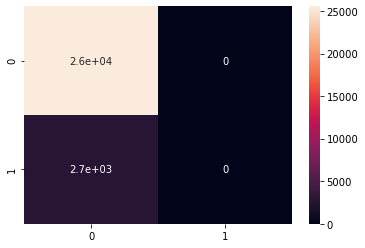

In [108]:
sns.heatmap(cm_log_reg_model, annot=True);

In [109]:
cr_log_reg_model = classification_report(y_Test, y_pred)
print(cr_log_reg_model)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     25538
           1       0.00      0.00      0.00      2743

    accuracy                           0.90     28281
   macro avg       0.45      0.50      0.47     28281
weighted avg       0.82      0.90      0.86     28281



C:\Users\maagarwal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maagarwal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maagarwal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 1.6.1 Accuracy on training Data 

In [110]:
y_pred_ontrain = log_reg_model.predict(X_Train)
cr_log_reg_model_train = classification_report(y_Train, y_pred_ontrain)
print(cr_log_reg_model_train)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    102626
           1       0.00      0.00      0.00     10497

    accuracy                           0.91    113123
   macro avg       0.45      0.50      0.48    113123
weighted avg       0.82      0.91      0.86    113123



C:\Users\maagarwal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maagarwal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maagarwal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
print('Logistic Regression Train score(mean accuracy) without SMOTE ',log_reg_model.score(X_Train,y_Train) ,'\n')
print('Logistic Regression Test score(mean accuracy) without SMOTE ',log_reg_model.score(X_Test,y_Test))

Logistic Regression Train score(mean accuracy) without SMOTE  0.9072071992433015 

Logistic Regression Test score(mean accuracy) without SMOTE  0.903009087373148


### Logistic Regression : Accuracy on Training Data <font color='red'> 90.6% </font>  , Accuracy on Test Data <font color='red'> 90.5% </font>

### 1.6.2 Using SMOTE to balance the class 

In [112]:
#pip install -U imbalanced-learn

In [113]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_Train_sm, y_Train_sm= sm.fit_resample(X_Train, y_Train.astype('int'))

### Samples before SMOTE 

In [118]:
y_Train.shape

(113123,)

### Samples after SMOTE 

In [117]:
y_Train_sm.shape

(205252,)

### Apply LogisticRegression model

In [119]:
lr_with_smote = LogisticRegression(random_state=20,solver='liblinear')
lr_model_with_smote = lr_with_smote.fit(X_Train_sm, y_Train_sm)

y_pred_smote=lr_model_with_smote.predict(X_Test)

print(classification_report(y_Test,y_pred_smote))

              precision    recall  f1-score   support

           0       0.97      0.75      0.85     25538
           1       0.25      0.76      0.37      2743

    accuracy                           0.75     28281
   macro avg       0.61      0.75      0.61     28281
weighted avg       0.90      0.75      0.80     28281



In [120]:
print('Logistic Regression Train score(mean accuracy) with SMOTE',lr_model_with_smote.score(X_Train_sm,y_Train_sm) ,'\n')
print('Logistic Regression Test score(mean accuracy) with SMOTE ',lr_model_with_smote.score(X_Test,y_Test))

Logistic Regression Train score(mean accuracy) with SMOTE 0.7557344142809814 

Logistic Regression Test score(mean accuracy) with SMOTE  0.7531558290018033


### Logistic Regression : Accuracy on Training Data <font color='red'> 75.5% </font>  , Accuracy on Test Data <font color='red'> 75.6% </font>

## 1.6.3 Using Descision Tree 

#### 1.6.3.1 Descision Tree without SMOTE 

In [121]:
from sklearn.tree import DecisionTreeClassifier
d_tree = DecisionTreeClassifier(random_state=10)
d_tree_model=d_tree.fit(X_Train,y_Train)

In [122]:
y_pred_d_tree = d_tree_model.predict(X_Test)

In [123]:
print(classification_report(y_Test,y_pred_d_tree))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     25538
           1       0.64      0.68      0.66      2743

    accuracy                           0.93     28281
   macro avg       0.80      0.82      0.81     28281
weighted avg       0.93      0.93      0.93     28281



In [124]:
print('Descision Tree: Train score(mean accuracy) without SMOTE',d_tree_model.score(X_Train,y_Train) ,'\n')
print('Descision Tree: Test score(mean accuracy) without SMOTE ',d_tree_model.score(X_Test,y_Test))

Descision Tree: Train score(mean accuracy) without SMOTE 1.0 

Descision Tree: Test score(mean accuracy) without SMOTE  0.9326756479615289


### Descision tree on Train data

In [125]:
y_pred_ontrain = d_tree_model.predict(X_Train)
dtree_log_reg_model_train = classification_report(y_Train, y_pred_ontrain)
print(dtree_log_reg_model_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    102626
           1       1.00      1.00      1.00     10497

    accuracy                           1.00    113123
   macro avg       1.00      1.00      1.00    113123
weighted avg       1.00      1.00      1.00    113123



#### 1.6.3.1 Descision Tree "with" SMOTE 

In [126]:
from sklearn.tree import DecisionTreeClassifier
d_tree_sm = DecisionTreeClassifier(random_state=10)
d_tree_model_with_smote=d_tree_sm.fit(X_Train_sm,y_Train_sm)

In [127]:
y_pred_d_tree_sm = d_tree_model_with_smote.predict(X_Test)

In [128]:
print(classification_report(y_Test,y_pred_d_tree_sm))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     25538
           1       0.63      0.66      0.64      2743

    accuracy                           0.93     28281
   macro avg       0.79      0.81      0.80     28281
weighted avg       0.93      0.93      0.93     28281



In [129]:
print('Descision Tree: Train score(mean accuracy) with SMOTE',d_tree_model.score(X_Train_sm,y_Train_sm) ,'\n')
print('Descision Tree: Test score(mean accuracy) with SMOTE ',d_tree_model.score(X_Test,y_Test))

Descision Tree: Train score(mean accuracy) with SMOTE 0.8680061582834759 

Descision Tree: Test score(mean accuracy) with SMOTE  0.9326756479615289


## 1.6.4 Using Random forest

In [130]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
rand_forest_classifier=RandomForestClassifier(random_state=10)
rand_forest_classifier_model=rand_forest_classifier.fit(X_Train_sm,y_Train_sm)

In [131]:
y_pred_rfc_sm=rand_forest_classifier_model.predict(X_Test)

In [132]:
print(classification_report(y_Test,y_pred_rfc_sm))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     25538
           1       0.93      0.67      0.78      2743

    accuracy                           0.96     28281
   macro avg       0.95      0.83      0.88     28281
weighted avg       0.96      0.96      0.96     28281



In [133]:
print('Randon Forest Tree: Train score with SMOTE',rand_forest_classifier_model.score(X_Train_sm,y_Train_sm) ,'\n')
print('Randon Forest Tree: Test score with SMOTE ',rand_forest_classifier_model.score(X_Test,y_Test))

Randon Forest Tree: Train score with SMOTE 0.9999610235223043 

Randon Forest Tree: Test score with SMOTE  0.9630847565503341


### Random forest model on training data 

In [134]:
y_pred_ontrain = rand_forest_classifier.predict(X_Train)
dtree_rand_f_model_train = classification_report(y_Train, y_pred_ontrain)
print(dtree_rand_f_model_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    102626
           1       1.00      1.00      1.00     10497

    accuracy                           1.00    113123
   macro avg       1.00      1.00      1.00    113123
weighted avg       1.00      1.00      1.00    113123



## 1.6.5 Artificical Neural Network

In [135]:
import tensorflow as tf

In [136]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))

In [137]:
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))

In [138]:
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))

In [139]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [140]:
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [142]:
X_Train[0]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,
       0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 64726,
       1, 32720.650000000005, 148.01409707546267], dtype=object)

In [143]:
X_Train=np.asarray(X_Train).astype(np.float32)
y_Train=np.asarray(y_Train).astype(np.float32)


In [144]:
ann.fit(X_Train, y_Train, batch_size=32, epochs=20)

Epoch 1/20
3536/3536 [==============================] - 4s 923us/step - loss: 24.0895 - accuracy: 0.9168
Epoch 2/20
3536/3536 [==============================] - 3s 939us/step - loss: 5.8366 - accuracy: 0.9249
Epoch 3/20
3536/3536 [==============================] - 3s 954us/step - loss: 0.6777 - accuracy: 0.9396
Epoch 4/20
3536/3536 [==============================] - 3s 928us/step - loss: 0.2052 - accuracy: 0.9525
Epoch 5/20
3536/3536 [==============================] - 3s 969us/step - loss: 0.2031 - accuracy: 0.9509
Epoch 6/20
3536/3536 [==============================] - 4s 1ms/step - loss: 0.1963 - accuracy: 0.9541
Epoch 7/20
3536/3536 [==============================] - 6s 2ms/step - loss: 0.2705 - accuracy: 0.9231
Epoch 8/20
3536/3536 [==============================] - 7s 2ms/step - loss: 0.3012 - accuracy: 0.9187
Epoch 9/20
3536/3536 [==============================] - 5s 1ms/step - loss: 0.2039 - accuracy: 0.9564
Epoch 10/20
3536/3536 [==============================] - 4s 1ms/step - 

In [145]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                960       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
_________________________________________________________________


In [147]:
X_Test=np.asarray(X_Test).astype(np.float32)
#y_Train=np.asarray(y_Train).astype(np.float32)

In [148]:
y_pred_ann_interim = ann.predict(X_Test)
y_pred_ann = (y_pred_ann_interim > 0.5)

884/884 [==============================] - 1s 705us/step


In [149]:
print(classification_report(y_Test,y_pred_ann))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     25538
           1       0.00      0.00      0.00      2743

    accuracy                           0.90     28281
   macro avg       0.45      0.50      0.47     28281
weighted avg       0.82      0.90      0.86     28281



C:\Users\maagarwal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maagarwal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maagarwal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [151]:
print('Randon Forest Tree: Train score with SMOTE',rand_forest_classifier_model.score(X_Train,y_Train) ,'\n')
print('Randon Forest Tree: Test score with SMOTE ',rand_forest_classifier_model.score(X_Test,y_Test))

Randon Forest Tree: Train score with SMOTE 0.9999292805176666 

Randon Forest Tree: Test score with SMOTE  0.9630847565503341


In [150]:
set(y_Test) - set(y_pred_ann)

TypeError: unhashable type: 'numpy.ndarray'

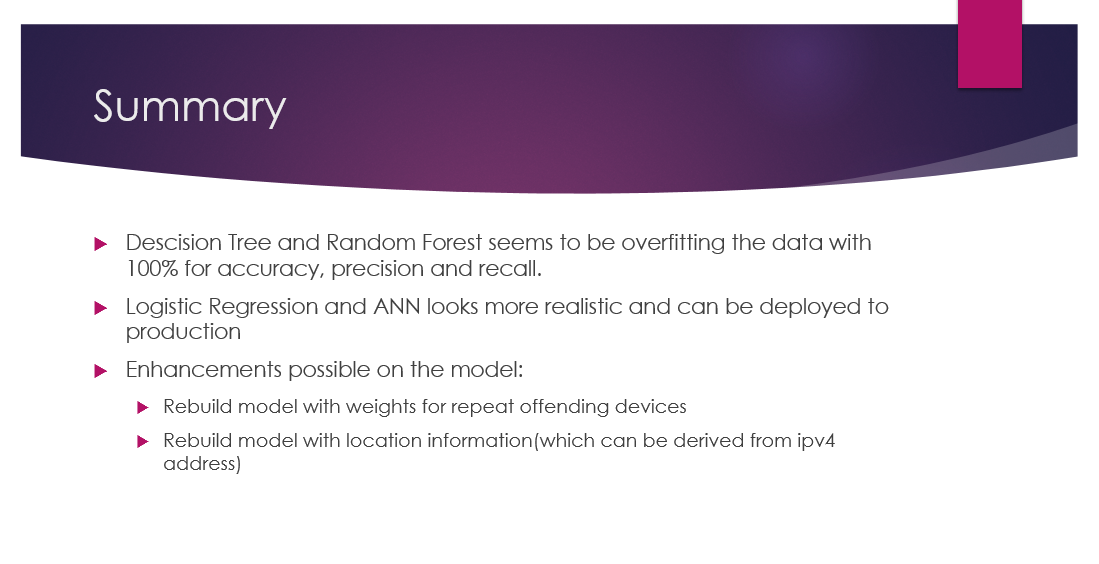